This notebook is similar to the end of the infilling_dineof notebook in that it is used to calculate statistics for the non-infilled Landsat data. The csv scenes used in this notebook are those generated by the landsat_scenes notebook.

In [23]:
# imports
from google.colab import drive
drive.mount('/content/drive', force_remount=True)
from datetime import datetime as dt
import matplotlib.pyplot as plt
import scipy.stats as sci
import numpy as np
import csv

# switch index depending on choice of satellite
index = 1
landsat_choices = ["landsat_5", "landsat_7", "landsat_8"]
date_choices = ["L5_dates", "L7_dates", "L8_dates"]
cloud_choices = ["L5_clouds", "L7_clouds", "L8_clouds"]
path = '/content/drive/MyDrive/Research/'

Mounted at /content/drive


# Loading Individual Satellite Data

In [ ]:
# loads the cloud and dates arrays, as well as the regular scenes

# paths to the data
path1 = path + 'landsat_scenes/csv_scenes/' + landsat_choices[index] + '/'
path2 = path + 'landsat_scenes/dates_clouds/'

# function that reads csv files
def readCSV(fpath, fname):
  file = open(fpath + fname + ".csv")
  csvreader = csv.reader(file)
  array = []
  for row in csvreader:
    array.append(row)
  return np.array(array)

# loads the cloud and dates data
sizes = [[1130,800], [1130,800], [1130,800]]
clouds = np.squeeze(readCSV(path2, cloud_choices[index]), 1).astype(float)
dates = np.squeeze(readCSV(path2, date_choices[index]), 1)
all_scenes = np.zeros([np.shape(dates)[0], sizes[index][0], sizes[index][1]])

# function that reads csv files
def readCSV(fpath, fname):
  file = open(fpath + fname + ".csv")
  csvreader = csv.reader(file)
  scene = np.zeros([sizes[index][0], sizes[index][1]])
  i = 0
  for row in csvreader:
    scene[i,:] = row
    i += 1
  return scene

# loads the regular scenes
for i in range(len(dates)):
  print("Scene " + str(i+1) + " of " + str(len(dates)))
  scene = readCSV(path1, dates[i]).astype(float)
  all_scenes[i,:,:] = scene

In [3]:
# loads the buoy data

# file path for the buoy data
fpath = path + 'buoy_data/'
buoys = ["bid2", "bid3", "bid4", "bid5", "bid6", "bid7",
          "bid8", "bid9", "bid10", "bid15", "bid16", "bid17"]
all_buoy_data = []

# function that reads csv files
def readCSV(buoy):
  file = open(fpath + buoy + ".csv")
  csvreader = csv.reader(file)
  buoy_data = []
  count = 0
  for row in csvreader:
    if count != 0 and count != 1:
      row[3] = convert_time(row[3])
      buoy_data.append(row[2:4])
    count += 1
  buoy_data = np.array(buoy_data)
  all_buoy_data.append(buoy_data)

# function that converts time from date/time to poxis time
def convert_time(time):
  date = time[0:10]
  time = time[11:19]
  stamp = dt.strptime(date + " " + time, '%Y-%m-%d %H:%M:%S').timestamp()
  return(stamp)

# loads the buoy data
for buoy in buoys:
  readCSV(buoy)
for i in range(len(buoys)):
  all_buoy_data[i] = all_buoy_data[i].astype(float)

In [4]:
# takes temporal averages of the buoy data centered around when Landsat
# scenes were taken, and spatial averages of the Landsat data centered
# around the buoy locations

# creates the data structures
buoy_locations = [[60,240], [125,295], [130,305], [220,12], [255,65], [280,263], [255,645], [365,360], [400,155], [386,295], [573,185], [940,70]]
num_buoys = len(buoy_locations)
num_dates = np.shape(dates)[0]
buoy_data = np.zeros([num_buoys, num_dates])
landsat_data = np.zeros([num_buoys, num_dates])

# function that takes a spatial average of a Landsat scene
def spatial_average(scene):
  averages = np.zeros(num_buoys)
  for i in range(num_buoys):
    buoy_location = buoy_locations[i]
    buoy_x = buoy_location[0]
    buoy_y = buoy_location[1]
    averages[i] = np.nanmean(scene[buoy_x-2:buoy_x+3, buoy_y-2:buoy_y+3])
  return averages

# function that takes a temporal average of buoy data
def temporal_average(date):
  stamp = convert_time(date + ".15:15:00.")
  averages = np.empty(num_buoys)*np.nan
  for i in range(num_buoys):
    times = all_buoy_data[i][:,1]
    time_differences = np.abs(times - stamp)
    if (np.amin(time_differences) < 15*60):
      min_index = np.argmin(time_differences)
      temps = all_buoy_data[i][:,0]
      temps_subset = temps[min_index-2:min_index+3]
      averages[i] = np.nanmean(temps_subset)
  return averages

# function that converts time from date/time to poxis time
def convert_time(time):
  date = time[0:10]
  time = time[11:19]
  stamp = dt.strptime(date + " " + time, '%Y-%m-%d %H:%M:%S').timestamp()
  return(stamp)

# fills in the data structures with the temporal and spatial averages
for i in range(num_dates):
  scene = all_scenes[i,:,:]
  landsat_data[:,i] = spatial_average(scene)
  buoy_data[:,i] = temporal_average(dates[i])

# saves the data
%cd '/content/drive/MyDrive/Research/bias_corrected'
np.savetxt(landsat_choices[index] + "_temp_data" + ".csv", landsat_data, delimiter=",")
np.savetxt(landsat_choices[index] + "_buoy_data" + ".csv", buoy_data, delimiter=",")

<ipython-input-4-be179ff8b4b8>:19: RuntimeWarning: Mean of empty slice
  averages[i] = np.nanmean(scene[buoy_x-2:buoy_x+3, buoy_y-2:buoy_y+3])
<ipython-input-4-be179ff8b4b8>:33: RuntimeWarning: Mean of empty slice
  averages[i] = np.nanmean(temps_subset)


/content/drive/MyDrive/Research/bias_corrected


# Compiling All Satellite Data

In [17]:
# path to the data
fpath1 = path + 'bias_corrected/'
fpath2 = path + 'landsat_scenes/dates_clouds/'

# function that reads csv files
def readCSV(fpath, fname):
  file = open(fpath + fname + ".csv")
  csvreader = csv.reader(file)
  array = []
  for row in csvreader:
    array.append(row)
  return np.array(array)

# loads all of the buoy and Landsat data for each satellite
landsat_5_data = readCSV(fpath1, "landsat_5_temp_data").astype(float)
landsat_7_data = readCSV(fpath1,"landsat_7_temp_data").astype(float)
landsat_8_data = readCSV(fpath1,"landsat_8_temp_data").astype(float)
buoy_5_data = readCSV(fpath1, "landsat_5_buoy_data").astype(float)
buoy_7_data = readCSV(fpath1,"landsat_7_buoy_data").astype(float)
buoy_8_data = readCSV(fpath1,"landsat_8_buoy_data").astype(float)
clouds_5 = np.squeeze(readCSV(fpath2, "L5_clouds"), 1).astype(float)
clouds_7 = np.squeeze(readCSV(fpath2, "L7_clouds"), 1).astype(float)
clouds_8 = np.squeeze(readCSV(fpath2, "L8_clouds"), 1).astype(float)
dates_5 = np.squeeze(readCSV(fpath2, "L5_dates"), 1)
dates_7 = np.squeeze(readCSV(fpath2, "L7_dates"), 1)
dates_8 = np.squeeze(readCSV(fpath2, "L8_dates"), 1)

# landsat marker arrays
landsat_5_marker = []
landsat_7_marker = []
landsat_8_marker = []
for i in range(len(dates_5)):
  landsat_5_marker.append("landsat_5")
for i in range(len(dates_7)):
  landsat_7_marker.append("landsat_7")
for i in range(len(dates_8)):
  landsat_8_marker.append("landsat_8")

# puts all of data into big arrays
all_dineof_data = np.concatenate((landsat_5_data, landsat_7_data, landsat_8_data), 1)
all_buoy_data = np.concatenate((buoy_5_data, buoy_7_data, buoy_8_data), 1)
all_clouds = np.concatenate((clouds_5, clouds_7, clouds_8), 0)
all_dates = np.concatenate((dates_5, dates_7, dates_8), 0)
all_markers = np.array(landsat_5_marker + landsat_7_marker + landsat_8_marker)

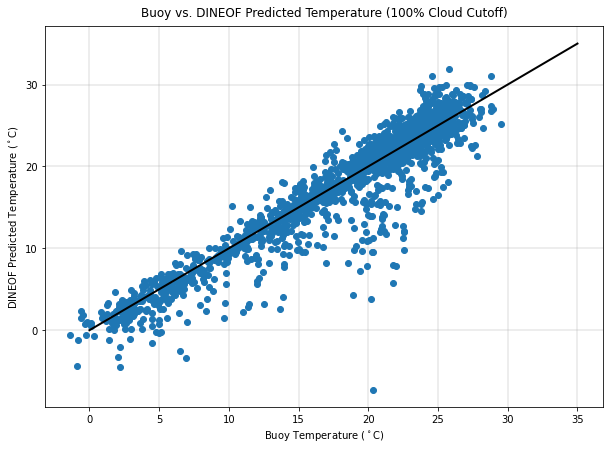

In [24]:
# plots the Landsat versus the buoy data for all satellites

# filters by cloud cutoff and plots
plot_cloud_cutoff = 100
buoy_data_filtered = np.squeeze(all_buoy_data[:, np.nonzero(all_clouds < plot_cloud_cutoff)],1)
dineof_data_filtered = np.squeeze(all_dineof_data[:, np.nonzero(all_clouds < plot_cloud_cutoff)],1)
fig, ax = plt.subplots(figsize=(10, 7))
ax.scatter(buoy_data_filtered, dineof_data_filtered);
ax.plot([0,35],[0,35], c='black', lw=2);
plt.title("Buoy vs. DINEOF Predicted Temperature (" + str(plot_cloud_cutoff) + "% Cloud Cutoff)", pad = 10);
plt.xlabel("Buoy Temperature ($^\circ$C)");
plt.ylabel("DINEOF Predicted Temperature ($^\circ$C)");
ax.set_axisbelow(True)
plt.grid(lw=0.45)

Mean: 0.3204315382880306
Standard Deviation: 2.507329141011246
Skewness: 2.424802533040536
Kurtosis: 12.899806065334955


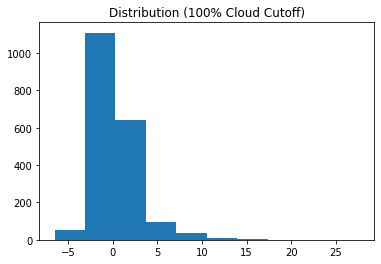

In [25]:
# calculates statistics for the difference between the Landsat
# data and the buoy data for all satellites

# filters by cloud cutoff and calculates statistics
buoy_data_filtered = np.squeeze(all_buoy_data[:, np.nonzero(all_clouds < plot_cloud_cutoff)],1)
dineof_data_filtered = np.squeeze(all_dineof_data[:, np.nonzero(all_clouds < plot_cloud_cutoff)],1)
difference = (buoy_data_filtered-dineof_data_filtered).flatten()
mean_val = np.nanmean(difference)
std_val = np.nanstd(difference)
skew_val = sci.skew(difference, nan_policy='omit')
kurtosis_val = sci.kurtosis(difference, nan_policy='omit')
print('Mean: ' + str(mean_val))
print('Standard Deviation: ' + str(std_val))
print('Skewness: ' + str(skew_val))
print('Kurtosis: ' + str(kurtosis_val))
plt.hist(difference)
plt.title('Distribution (' + str(plot_cloud_cutoff) + "% Cloud Cutoff)");

In [20]:
# creates the metadata file for the completed product
dates_to_sort = [dt.strptime(date, "%Y-%m-%d") for date in all_dates]
sort_indices = np.argsort(dates_to_sort)
all_dates_sorted = all_dates[sort_indices]
all_clouds_sorted = all_clouds[sort_indices]
all_markers_sorted = all_markers[sort_indices]
metadata = np.empty((len(all_dates_sorted) + 1, 3), dtype="<U20")
metadata[0,:] = ["date", "% cloud cover", "landsat"]
metadata[1:,0] = all_dates_sorted
metadata[1:,1] = all_clouds_sorted
metadata[1:,2] = all_markers_sorted
%cd '/content/drive/MyDrive/Data/Non-Infilled'
np.savetxt("metadata.csv", metadata, delimiter=",", fmt='%s')

/content/drive/MyDrive/Data/Non-Infilled
